In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as T
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import time
import re

# --- Configuration ---
# IMPORTANT: Verify this path is correct on your system
DATA_DIR = "path/to/your/quickdraw/data"  # Replace with your actual data directory
CLASS_NAMES = [
    'Airplane', 'Apple', 'Bicycle', 'Book', 'Car', 'Cat', 'Chair', 'Clock',
    'Dog', 'Door', 'Eye', 'Fish', 'Flower', 'Fork', 'House', 'Key', 'Ladder',
    'Moon', 'Mountain', 'Pizza', 'Rainbow', 'Shoe', 'Smiley Face', 'Star',
    'Stop Sign', 'Sun', 'Table', 'Tennis Racquet', 'Tree', 'Wheel'
]
NUM_CLASSES = len(CLASS_NAMES)
SAMPLES_PER_CLASS = 10000
BATCH_SIZE = 64 # Adjust based on your GPU memory
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
EPOCHS = 15 # Total number of epochs to train
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = 2

# --- RESUME TRAINING CONFIG ---
# Path to the saved model checkpoint, set this to the model you want to load
CHECKPOINT_PATH = "path/to/your/checkpoint.pth"  # Replace with your actual checkpoint path
RESUME_TRAINING = True  # Set to True to resume training, False to start fresh
START_EPOCH = None  # Will be determined from the checkpoint filename if None

if RESUME_TRAINING:
    print(f"Resuming training from checkpoint: {CHECKPOINT_PATH}")

# --- Base Dataset ---
class QuickDrawDataset(Dataset):
    def __init__(self, data_dir, class_names, samples_per_class):
        self.data_dir = data_dir
        self.class_names = class_names
        self.samples_per_class = samples_per_class
        self.data = []
        self.labels = []
        self.class_to_idx = {name: i for i, name in enumerate(class_names)}

        print("Loading dataset metadata...")
        start_time = time.time()
        for i, name in enumerate(tqdm(class_names, desc="Scanning classes")):
            safe_name = name.lower()
            file_path = os.path.join(data_dir, f"{safe_name}.npy")
            if not os.path.exists(file_path):
                print(f"Warning: File not found, skipping class '{name}': {file_path}")
                continue
            try:
                class_data = np.load(file_path)[:samples_per_class]
                class_data_reshaped = class_data.reshape(-1, 28, 28).astype(np.uint8)
                self.data.append(class_data_reshaped)
                self.labels.extend([i] * len(class_data_reshaped))
            except Exception as e:
                print(f"Error loading or processing {file_path}: {e}")

        if not self.data:
             raise RuntimeError("No data loaded. Check DATA_DIR, file names, and file contents.")

        self.data = np.concatenate(self.data, axis=0)
        self.labels = np.array(self.labels, dtype=np.int64)
        load_time = time.time() - start_time
        print(f"Dataset loaded successfully in {load_time:.2f} seconds.")
        print(f"Total samples: {len(self.data)}")
        print(f"Data shape: {self.data.shape}")
        print(f"Labels shape: {self.labels.shape}")


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return the raw 28x28 uint8 image data and the integer label
        image_data = self.data[idx] # Shape (28, 28), dtype uint8
        label = self.labels[idx]    # dtype int64
        return image_data, label

# --- Data Augmentation and Transforms ---
weights = ConvNeXt_Tiny_Weights.DEFAULT
base_preprocess = weights.transforms()
print("Base transforms (from weights):", base_preprocess)

# Extract normalization stats and target size
try:
    norm_mean = base_preprocess.mean
    norm_std = base_preprocess.std
    # Use crop_size as the definitive final image size model expects
    img_size = base_preprocess.crop_size[-1] # Usually 224 for ConvNeXt
    # Use resize_size recommended by weights for initial resizing
    resize_size = base_preprocess.resize_size[-1] # Usually slightly larger than crop_size
    print(f"Using ImageNet Mean: {norm_mean}, Std: {norm_std}")
    print(f"Target Crop Size: {img_size}, Resize Size: {resize_size}")
except Exception as e:
    print(f"Warning: Could not automatically extract mean/std/sizes from transforms ({e}). Using defaults.")
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    img_size = 224
    resize_size = 236 # Common resize before 224 crop


# --- Transform Pipelines ---

# Custom transform class for channel replication
class RepeatChannels(torch.nn.Module):
    """Replicates channels of a tensor."""
    def __init__(self, repeats=3):
        super().__init__()
        self.repeats = repeats

    def forward(self, img_tensor):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (C, H, W) to be replicated.
        Returns:
            Tensor: Tensor image with channels replicated (repeats, H, W).
        """
        if img_tensor.shape[0] == 1:
            img_tensor = img_tensor.repeat(self.repeats, 1, 1)
        elif img_tensor.shape[0] == self.repeats:
            pass # Already has correct channels
        else:
            raise ValueError(f"Input tensor has unexpected channel count: {img_tensor.shape[0]}. Expected 1 or {self.repeats}.")
        return img_tensor

# Training pipeline: includes augmentation
train_transform = T.Compose([
    T.ToPILImage(), # uint8 NumPy (H,W) -> PIL (L mode)
    T.Resize(resize_size, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(img_size), # Crop to the exact size the model expects
    T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    T.RandomHorizontalFlip(p=0.5),
    # T.TrivialAugmentWide(), # Optional: Stronger augmentation
    T.ToTensor(),   # PIL (L mode) -> Tensor [1, H, W], scales to [0.0, 1.0]
    RepeatChannels(repeats=3), # Tensor [1, H, W] -> Tensor [3, H, W]
    T.Normalize(mean=norm_mean, std=norm_std), # Normalize the [3, H, W] tensor
    # T.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)), # Optional
])

# Validation pipeline: only necessary preprocessing
val_transform = T.Compose([
    T.ToPILImage(), # uint8 NumPy (H,W) -> PIL (L mode)
    T.Resize(resize_size, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(img_size),
    T.ToTensor(),   # PIL (L mode) -> Tensor [1, H, W]
    RepeatChannels(repeats=3), # Tensor [1, H, W] -> Tensor [3, H, W]
    T.Normalize(mean=norm_mean, std=norm_std), # Normalize the [3, H, W] tensor
])

# --- Wrapper Dataset for Applying Transforms ---
class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        # 1. Get raw data (uint8 NumPy array, int64 label)
        image_data, label = self.subset[index]

        # 2. Apply the entire transform pipeline
        # This pipeline now correctly handles channel replication before normalization
        transformed_image = self.transform(image_data) # Should be [3, H, W] Tensor

        return transformed_image, label

    def __len__(self):
        return len(self.subset)


# --- Dataset Splitting Function ---
def create_dataloaders(data_dir, class_names, samples_per_class, batch_size, val_split, num_workers):
    full_dataset = QuickDrawDataset(data_dir, class_names, samples_per_class)
    total_size = len(full_dataset)
    if total_size == 0: raise ValueError("Dataset is empty.")
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    if train_size <= 0 or val_size <= 0: raise ValueError("Invalid train/val split size.")

    print(f"Splitting data: Train={train_size}, Validation={val_size}")
    generator = torch.Generator().manual_seed(42)
    train_subset, val_subset = random_split(full_dataset, [train_size, val_size], generator=generator)

    train_dataset_transformed = TransformedDataset(train_subset, train_transform)
    val_dataset_transformed = TransformedDataset(val_subset, val_transform)

    train_loader = DataLoader(
        train_dataset_transformed, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, persistent_workers=True if num_workers > 0 else False
    )
    val_loader = DataLoader(
        val_dataset_transformed, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True, persistent_workers=True if num_workers > 0 else False
    )
    print("DataLoaders created.")
    return train_loader, val_loader

# --- Model Definition ---
def get_model(num_classes, device):
    print("Loading ConvNeXt model...")
    weights = ConvNeXt_Tiny_Weights.DEFAULT
    model = convnext_tiny(weights=weights)
    try:
        num_ftrs = model.classifier[2].in_features
        model.classifier[2] = nn.Linear(num_ftrs, num_classes)
        print(f"Replaced final classifier layer for {num_classes} classes.")
    except Exception as e:
        print(f"Error modifying classifier layer: {e}")
        print("Model structure might have changed. Check model.classifier structure:")
        print(model.classifier); raise
    model = model.to(device)
    print("Model loaded and moved to device.")
    return model

# --- Training and Validation Functions ---
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        batch_acc = (predicted == labels).sum().item() / inputs.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    progress_bar = tqdm(loader, desc="Validating", leave=False)
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            batch_acc = (predicted == labels).sum().item() / inputs.size(0)
            progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

# --- New functions for checkpoint handling ---
def save_checkpoint(model, optimizer, scheduler, epoch, best_val_acc, val_acc):
    """Save a checkpoint with all necessary information to resume training"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'best_val_acc': best_val_acc,
        'val_acc': val_acc
    }
    checkpoint_path = f"checkpoint/convnext_quickdraw_checkpoint_epoch_{epoch+1}_acc_{val_acc:.4f}.pth"
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")
    return checkpoint_path

def load_checkpoint(checkpoint_path, model, optimizer=None, scheduler=None):
    """Load a checkpoint and return the epoch to resume from and best validation accuracy"""
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")
    
    print(f"Loading checkpoint from {checkpoint_path}")
    # Check if the checkpoint is a full checkpoint or just model weights
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    
    # If checkpoint is a dict with 'model_state_dict' key, it's a full checkpoint
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler is not None and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint.get('epoch', -1) + 1  # Resume from next epoch
        best_val_acc = checkpoint.get('best_val_acc', 0.0)
        print(f"Resuming from epoch {epoch} with best validation accuracy: {best_val_acc:.4f}")
    else:
        # Otherwise, assume it's just the model weights
        model.load_state_dict(checkpoint)
        # Try to extract epoch from filename
        match = re.search(r'epoch_(\d+)', os.path.basename(checkpoint_path))
        epoch = int(match.group(1)) if match else 0
        # Try to extract accuracy from filename
        match = re.search(r'acc_(\d+\.\d+)', os.path.basename(checkpoint_path))
        best_val_acc = float(match.group(1)) if match else 0.0
        print(f"Loaded model weights only. Estimated epoch: {epoch}, accuracy: {best_val_acc:.4f}")
    
    return epoch, best_val_acc

# --- Main Execution with Resume Logic ---
def main():
    try:
        train_loader, val_loader = create_dataloaders(
            DATA_DIR, CLASS_NAMES, SAMPLES_PER_CLASS, BATCH_SIZE, VAL_SPLIT, NUM_WORKERS
        )
    except (ValueError, RuntimeError) as e:
        print(f"Error creating dataloaders: {e}"); return

    model = get_model(NUM_CLASSES, DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
    
    # Initialize training variables
    start_epoch = 0
    best_val_acc = 0.0
    
    # Resume training if requested
    if RESUME_TRAINING and os.path.exists(CHECKPOINT_PATH):
        try:
            start_epoch, best_val_acc = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler)
            if START_EPOCH is not None:  # Override if explicitly specified
                start_epoch = START_EPOCH
            print(f"Training will resume from epoch {start_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            print("Starting fresh training instead")
    else:
        print("Starting fresh training")

    print("Starting training...")
    for epoch in range(start_epoch, EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, epoch, EPOCHS)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE)
        scheduler.step()
        end_time = time.time(); epoch_duration = end_time - start_time

        print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
        print(f"  Duration: {epoch_duration:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model (weights only)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_save_path = f"/kaggle/working/convnext_quickdraw_best_epoch_{epoch+1}_acc_{val_acc:.4f}.pth"
            print(f"  New best validation accuracy! Saving model to {model_save_path}")
            torch.save(model.state_dict(), model_save_path)
        
        # Save checkpoint (full state) every 3 epochs and on the last epoch
        if (epoch + 1) % 3 == 0 or epoch == EPOCHS - 1:
            save_checkpoint(model, optimizer, scheduler, epoch, best_val_acc, val_acc)
            
        print("-" * 20)

    print("\nTraining finished.")
    print(f"Best Validation Accuracy achieved: {best_val_acc:.4f}")

if __name__ == '__main__':
    main()

Loading model from models/ConvNeXt/convnext_quickdraw_checkpoint_epoch_3_acc_0.9540.pth...
Loading model from full checkpoint
Model loaded successfully
Found 12 images to process

Processing test_images/car.jpg...
Results for car.jpg:
  1. Car: 99.95%
  2. Wheel: 0.01%
  3. Mountain: 0.00%
  4. Bicycle: 0.00%
  5. Ladder: 0.00%


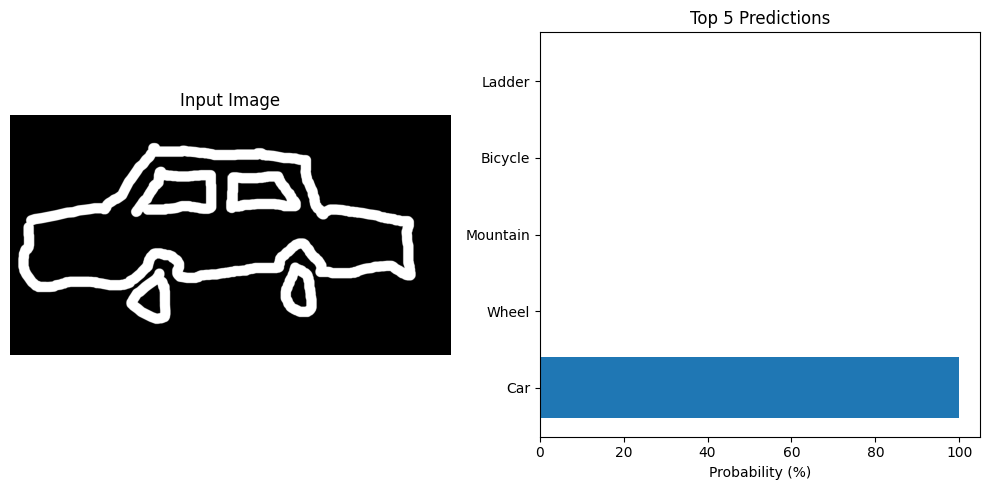


Processing test_images/cat.jpg...
Results for cat.jpg:
  1. Cat: 99.88%
  2. Dog: 0.08%
  3. Sun: 0.02%
  4. Airplane: 0.00%
  5. Ladder: 0.00%


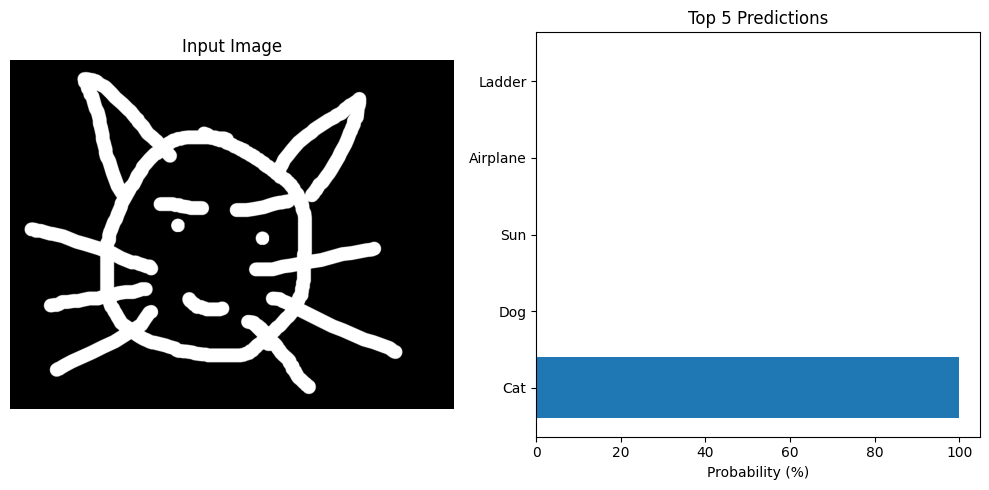


Processing test_images/cat2.jpg...
Results for cat2.jpg:
  1. Cat: 99.89%
  2. Dog: 0.06%
  3. Sun: 0.02%
  4. Airplane: 0.00%
  5. Chair: 0.00%


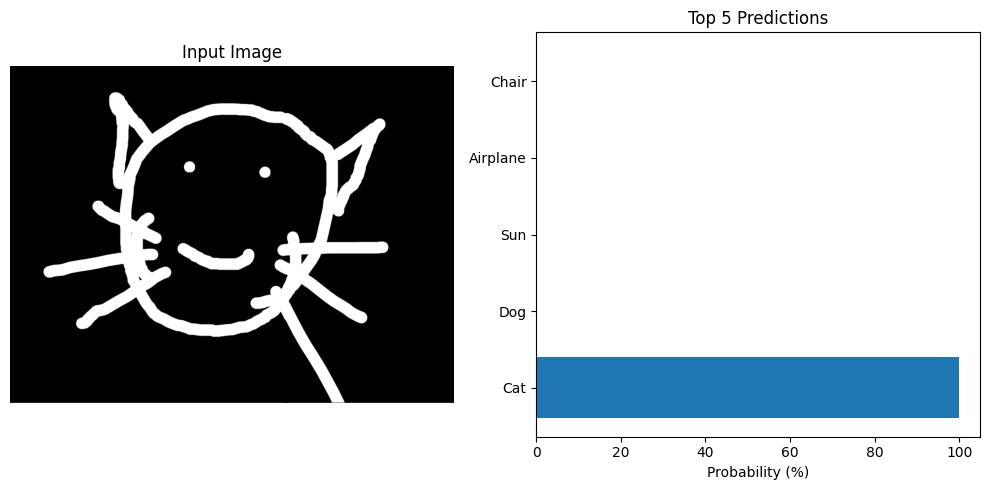


Processing test_images/clock.jpg...
Results for clock.jpg:
  1. Clock: 99.92%
  2. Moon: 0.04%
  3. Pizza: 0.01%
  4. Wheel: 0.01%
  5. Stop Sign: 0.01%


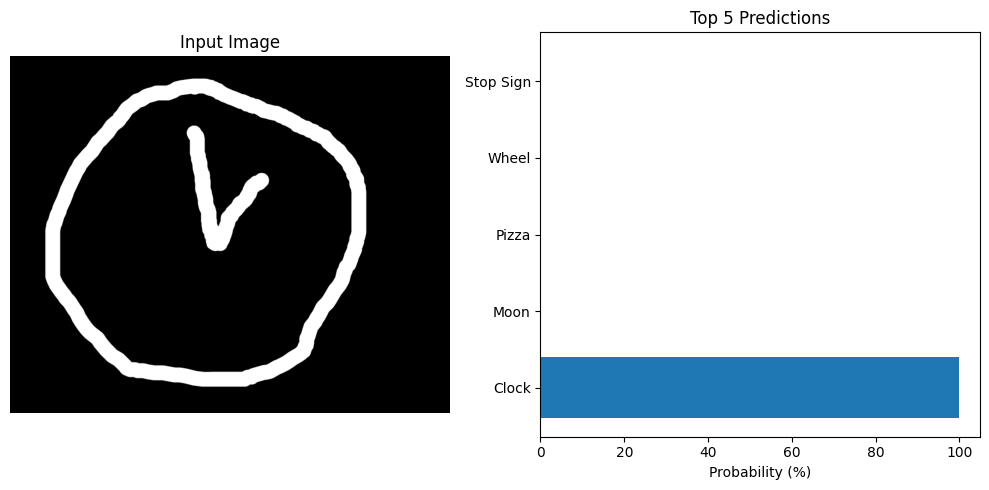


Processing test_images/flower.jpg...
Results for flower.jpg:
  1. Flower: 99.97%
  2. Sun: 0.01%
  3. Moon: 0.00%
  4. Shoe: 0.00%
  5. Star: 0.00%


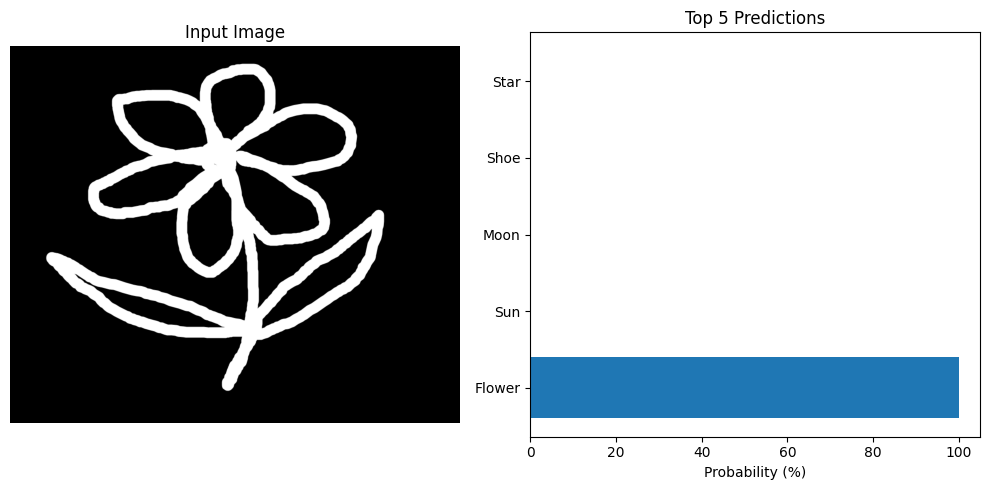


Processing test_images/House.jpg...
Results for House.jpg:
  1. House: 99.99%
  2. Door: 0.00%
  3. Chair: 0.00%
  4. Book: 0.00%
  5. Stop Sign: 0.00%


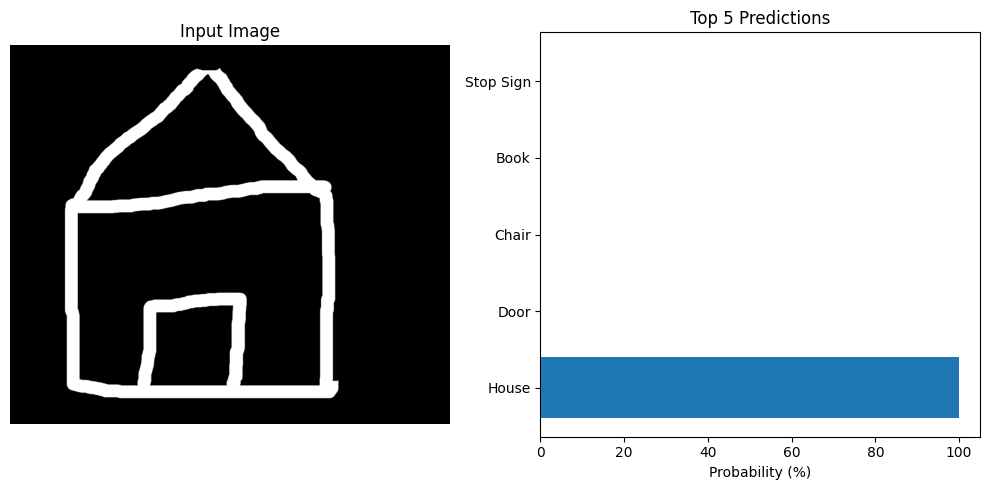


Processing test_images/pizza.jpg...
Results for pizza.jpg:
  1. Pizza: 97.88%
  2. Moon: 1.22%
  3. Smiley Face: 0.30%
  4. Fish: 0.24%
  5. Door: 0.07%


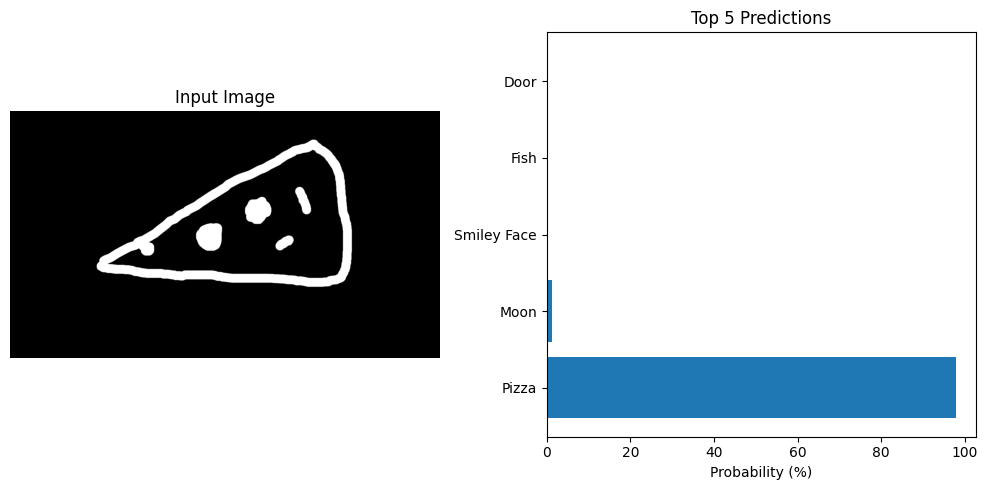


Processing test_images/plane.jpg...
Results for plane.jpg:
  1. Airplane: 99.87%
  2. Fish: 0.10%
  3. Car: 0.01%
  4. Table: 0.00%
  5. Dog: 0.00%


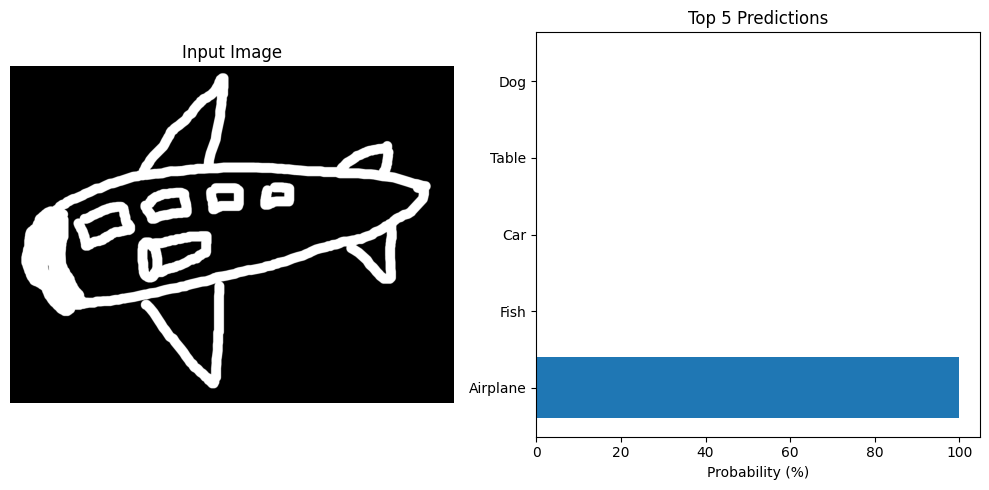


Processing test_images/shoe.jpg...
Results for shoe.jpg:
  1. Shoe: 99.95%
  2. Chair: 0.02%
  3. Dog: 0.01%
  4. Tennis Racquet: 0.01%
  5. Mountain: 0.00%


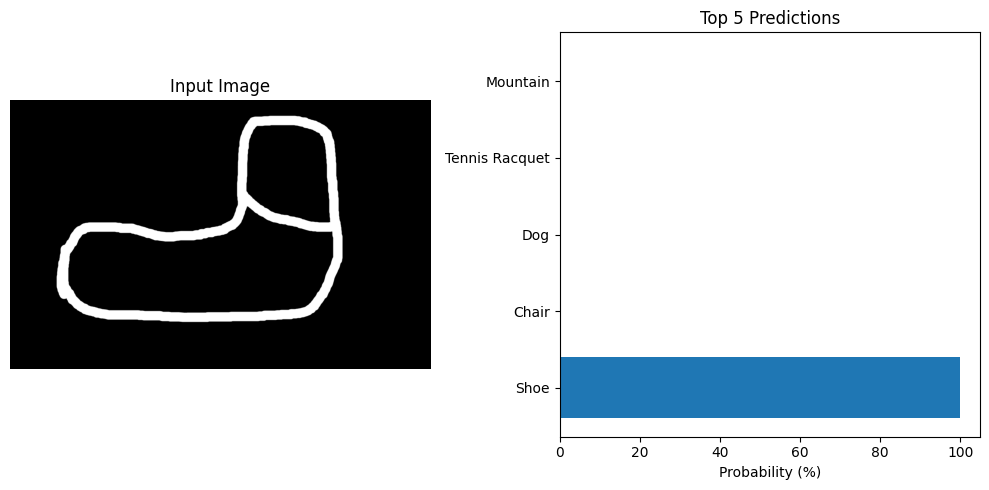


Processing test_images/star.jpg...
Results for star.jpg:
  1. Star: 99.93%
  2. Airplane: 0.01%
  3. Mountain: 0.01%
  4. House: 0.01%
  5. Pizza: 0.01%


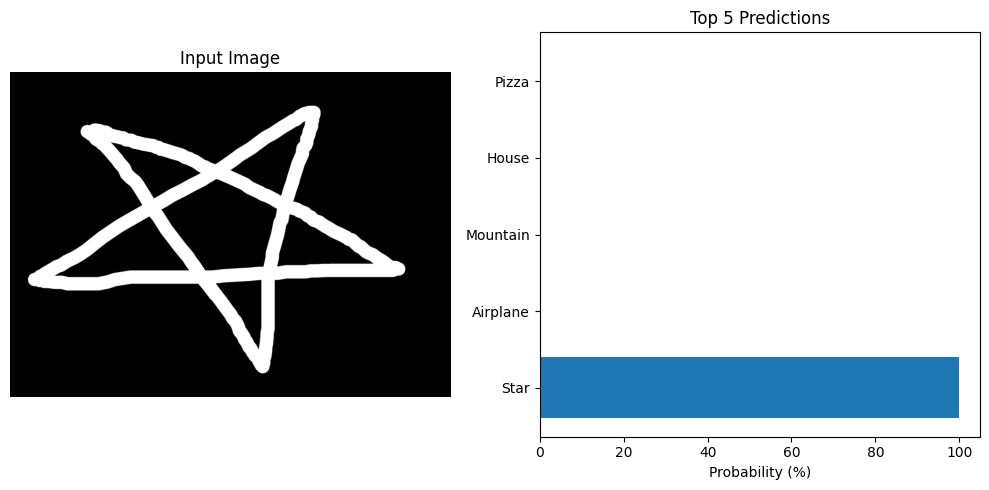


Processing test_images/stop_sign.jpg...
Results for stop_sign.jpg:
  1. Stop Sign: 100.00%
  2. Tennis Racquet: 0.00%
  3. Flower: 0.00%
  4. Car: 0.00%
  5. Smiley Face: 0.00%


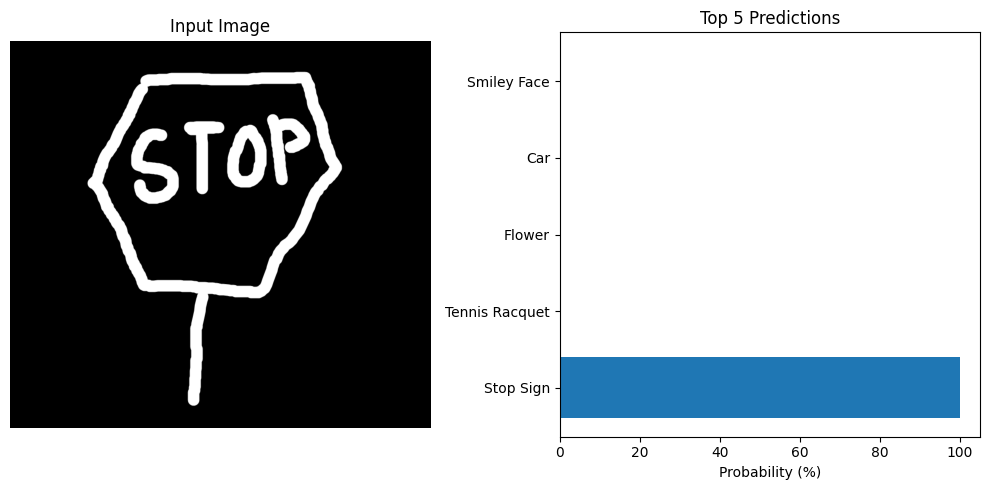


Processing test_images/wheel.jpg...
Results for wheel.jpg:
  1. Wheel: 61.72%
  2. Pizza: 37.91%
  3. Clock: 0.07%
  4. House: 0.06%
  5. Bicycle: 0.02%


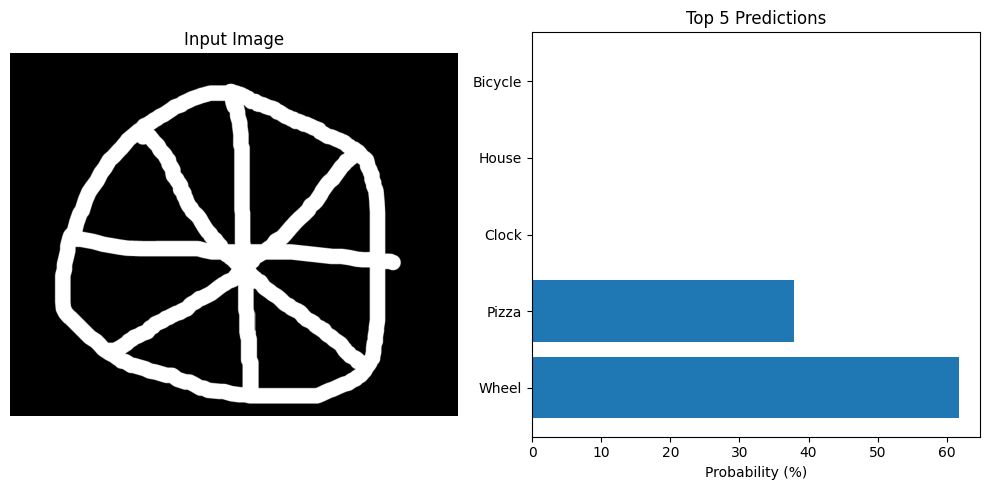

In [ ]:
import torch
import torchvision.transforms as T
from torchvision.models import convnext_tiny
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Model parameters - ensure these match your training configuration
NUM_CLASSES = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = [
    'Airplane', 'Apple', 'Bicycle', 'Book', 'Car', 'Cat', 'Chair', 'Clock',
    'Dog', 'Door', 'Eye', 'Fish', 'Flower', 'Fork', 'House', 'Key', 'Ladder',
    'Moon', 'Mountain', 'Pizza', 'Rainbow', 'Shoe', 'Smiley Face', 'Star',
    'Stop Sign', 'Sun', 'Table', 'Tennis Racquet', 'Tree', 'Wheel'
]

# Path to your saved model
MODEL_PATH = "model_path.pth"  # Update this to your model path


# --- Define the same preprocessing transforms used in training ---
# Custom transform class for channel replication (copied from your training code)
class RepeatChannels(torch.nn.Module):
    """Replicates channels of a tensor."""
    def __init__(self, repeats=3):
        super().__init__()
        self.repeats = repeats

    def forward(self, img_tensor):
        """
        Args:
            img_tensor (Tensor): Tensor image of size (C, H, W) to be replicated.
        Returns:
            Tensor: Tensor image with channels replicated (repeats, H, W).
        """
        if img_tensor.shape[0] == 1:
            img_tensor = img_tensor.repeat(self.repeats, 1, 1)
        elif img_tensor.shape[0] == self.repeats:
            pass  # Already has correct channels
        else:
            raise ValueError(f"Input tensor has unexpected channel count: {img_tensor.shape[0]}. Expected 1 or {self.repeats}.")
        return img_tensor

# Define normalization parameters (should match your training)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_size = 224
resize_size = 236

# Create preprocessing pipeline for test images
def get_transforms_for_test():
    """Create transforms for test images that match training preprocessing"""
    return T.Compose([
        T.Resize(resize_size, interpolation=T.InterpolationMode.BICUBIC),
        T.CenterCrop(img_size),
        T.ToTensor(),
        RepeatChannels(repeats=3),  # Ensure 3 channels for ConvNeXt
        T.Normalize(mean=norm_mean, std=norm_std),
    ])

# --- Load model ---
def load_model(model_path, num_classes, device):
    """Load the trained ConvNeXt model"""
    print(f"Loading model from {model_path}...")
    model = convnext_tiny()
    
    # Modify the classifier to match your number of classes
    num_ftrs = model.classifier[2].in_features
    model.classifier[2] = torch.nn.Linear(num_ftrs, num_classes)
    
    # Load the trained weights
    checkpoint = torch.load(model_path, map_location=device)
    
    # Check if this is a checkpoint dictionary or just model weights
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        print("Loading model from full checkpoint")
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        print("Loading model weights directly")
        model.load_state_dict(checkpoint)
        
    model = model.to(device)
    model.eval()
    print("Model loaded successfully")
    return model

# --- Image preprocessing and inference ---
def preprocess_image(image_path, transform):
    """Load and preprocess an image for inference"""
    try:
        # Load image as PIL image
        with Image.open(image_path) as img:
            # Convert to grayscale if it's not already
            if img.mode != 'L':
                img = img.convert('L')
            img = img.convert('L')
            
            # Apply transformations
            image_tensor = transform(img).unsqueeze(0)  # Add batch dimension
            return image_tensor
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

def predict_image(model, image_tensor, device, class_names):
    """Run inference on preprocessed image tensor"""
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        
    # Get probabilities
    probabilities = torch.nn.functional.softmax(outputs, dim=1)[0]
    
    # Get top 5 predictions
    top5_probs, top5_indices = torch.topk(probabilities, 5)
    
    results = []
    for i, (prob, idx) in enumerate(zip(top5_probs, top5_indices)):
        class_name = class_names[idx.item()]
        probability = prob.item() * 100
        results.append((class_name, probability))
    
    return results

# --- Visualization function ---
def display_results(image_path, predictions):
    """Display the image alongside its predictions"""
    # Open the image as PIL Image
    with Image.open(image_path) as img:
        # Convert to grayscale if it's not already
        if img.mode != 'L':
            img = img.convert('L')
        
        plt.figure(figsize=(10, 5))
        
        # Display image
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Input Image")
        plt.axis('off')
        
        # Display predictions
        plt.subplot(1, 2, 2)
        classes = [pred[0] for pred in predictions]
        probs = [pred[1] for pred in predictions]
        
        y_pos = np.arange(len(classes))
        plt.barh(y_pos, probs, align='center')
        plt.yticks(y_pos, classes)
        plt.xlabel('Probability (%)')
        plt.title('Top 5 Predictions')
        
        plt.tight_layout()
        plt.show()

# --- Main function to run inference on test images ---
def test_custom_images(model_path, test_dir, class_names):
    """Test model on all images in the specified directory"""
    # Load model
    model = load_model(model_path, len(class_names), DEVICE)
    
    # Get preprocessing transforms
    transform = get_transforms_for_test()
    
    # Get list of image files
    image_files = [f for f in os.listdir(test_dir) if (f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')) and f.lower() != 'bicycle.jpg' and f.lower() != 'ladder.jpg')]
    
    if not image_files:
        print(f"No image files found in {test_dir}")
        return
    
    print(f"Found {len(image_files)} images to process")
    
    # Process each image
    for image_file in image_files:
        image_path = os.path.join(test_dir, image_file)
        print(f"\nProcessing {image_path}...")
        
        # Preprocess image
        image_tensor = preprocess_image(image_path, transform)
        if image_tensor is None:
            continue
        
        # Run inference
        predictions = predict_image(model, image_tensor, DEVICE, class_names)
        
        # Display results
        print(f"Results for {image_file}:")
        for i, (class_name, probability) in enumerate(predictions):
            print(f"  {i+1}. {class_name}: {probability:.2f}%")
        
        # Display visualization
        display_results(image_path, predictions)

# --- Function to test a single image ---
def test_single_image(model_path, image_path, class_names):
    """Test model on a single image"""
    # Load model
    model = load_model(model_path, len(class_names), DEVICE)
    
    # Get preprocessing transforms
    transform = get_transforms_for_test()
    
    # Preprocess image
    print(f"Processing {image_path}...")
    image_tensor = preprocess_image(image_path, transform)
    if image_tensor is None:
        return
    
    # Run inference
    predictions = predict_image(model, image_tensor, DEVICE, class_names)
    
    # Display results
    print(f"Results for {os.path.basename(image_path)}:")
    for i, (class_name, probability) in enumerate(predictions):
        print(f"  {i+1}. {class_name}: {probability:.2f}%")
    
    # Display visualization
    display_results(image_path, predictions)

# --- Usage examples ---
if __name__ == '__main__':
    # Update these paths to match your model and test images
    MODEL_PATH = "model_path.pth"  # Update this path!
    TEST_IMAGES_DIR = "test_images"  # Update this path!

    # Option 1: Test all images in a directory
    test_custom_images(MODEL_PATH, TEST_IMAGES_DIR, CLASS_NAMES)
    
    # Option 2: Test a specific image
    # test_single_image(MODEL_PATH, "/path/to/specific/image.jpg", CLASS_NAMES)